Ctrl+Shift+P shows you a list of shortcut commands

In [102]:
import numpy as np
import pandas as pd
import scipy.io as sio
from scipy.fftpack import dct
from scipy.misc import imread
import matplotlib.pyplot as plt

### Load the training data

In [103]:
rawtraining = sio.loadmat('givenData/TrainingSamplesDCT_8.mat')
rawtraining.keys()
# print(rawtraining['TrainsampleDCT_BG'])

dict_keys(['__header__', '__version__', '__globals__', 'TrainsampleDCT_FG', 'TrainsampleDCT_BG'])

### Create a histogram of DCT value vs number of sets with this value. This will be used to determine the class conditional propabilities $p(\text{dct}|\text{cheetah})$ and $p(\text{dct}|\text{background})$ which are needed to calculate the likelihood ratio that will be our classifier $\frac{p(\text{dct}|\text{cheetah})p(\text{cheetah})}{p(\text{dct}|\text{background})p(\text{background})}>1$

Summary Statistics: DescribeResult(nobs=67392, minmax=(0.0, 4.1176470588235281), mean=0.062183293626689437, variance=0.13349717365715991, skewness=8.115502712816335, kurtosis=66.29102494266073)
Total Probability: 1.0000064


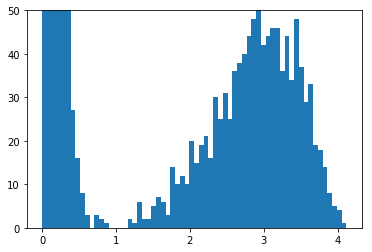

In [104]:
from scipy.stats import describe
numbins = 64
TrainsampleDCT_BG = rawtraining['TrainsampleDCT_BG']
flatBG = np.ndarray.flatten(TrainsampleDCT_BG)
datasummary = describe(flatBG)
print('Summary Statistics: {}'.format(datasummary))
bincntsBG = plt.hist(flatBG, bins=numbins)
bincntsBG = bincntsBG[0]
#print(bincntsBG)
totalcntsBG = np.sum(bincntsBG)
binprobBG = bincntsBG/totalcntsBG + 0.0000001
print('Total Probability: {}'.format(np.sum(binprobBG)))
plt.ylim([0,50])
plt.show()

Summary Statistics: DescribeResult(nobs=16000, minmax=(0.0, 3.1387254901960779), mean=0.052550818424827728, variance=0.029996217619030981, skewness=8.053710258097745, kurtosis=75.06687135691573)
Total Probability: 1.0000064


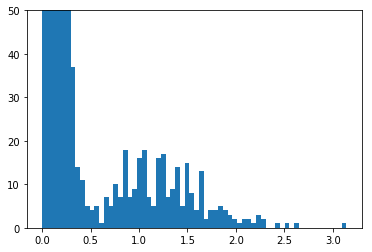

In [105]:
from scipy.stats import describe
TrainsampleDCT_FG = rawtraining['TrainsampleDCT_FG']
flatFG = np.ndarray.flatten(TrainsampleDCT_FG)
datasummary = describe(flatFG)
print('Summary Statistics: {}'.format(datasummary))
bincntsFG = plt.hist(flatFG, bins=numbins)
bincntsFG = bincntsFG[0]
totalcntsFG = np.sum(bincntsFG)
binprobFG = bincntsFG/totalcntsFG + 0.0000001
print('Total Probability: {}'.format(np.sum(binprobFG)))
plt.ylim([0,50])
plt.show()

### Function to determine the 2-D discrete time transform from 1-D transforms

In [106]:
def dct2(img):
    """ Get 2D Cosine Transform of Image
    """
    return dct(dct(img.T, norm='ortho').T, norm='ortho')

### Read in the grayscale image of a cheetah and convert to array of doubles to match the training data format

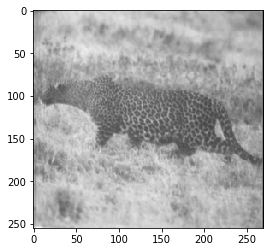

In [107]:
rawimage = imread('givenData/cheetah.bmp', 'L')
plt.imshow(rawimage, cmap='gray')
plt.show()

doubleimage = rawimage.astype(float)/255

# print(rawimage[:10,:10])
# print(doubleimage[:10,:10])

### Go through the cheetah image in blocks of 8x8 pixels with a stride of 1 pixel, take the 2-D DCT of each of these blocks, take the magnitude, vectorize using the zigzag pattern given and choose the index of the second largest element. This will be the feature we use to determine cheetah vs background going forward.

In [113]:
blksizecol = 8
blksizerow = 8
priorFG = 0.2
priorBG = 1-priorFG
numrow, numcol = doubleimage.shape
cheetahmask = np.zeros((numrow,numcol))
for mm in range(numrow - blksizerow):
    for nn in range(numcol - blksizecol):
        block = doubleimage[mm:mm+blksizerow, nn:nn+blksizecol]
        blockdct = np.absolute(dct2(block))        
        blockdctflat = np.ndarray.flatten(blockdct)
        
        zigzagpattern = np.array([[ 0, 1, 5, 6,14,15,27,28],
                                  [ 2, 4, 7,13,16,26,29,42],
                                  [ 3, 8,12,17,25,30,41,43],
                                  [ 9,11,18,24,31,40,44,53],
                                  [10,19,23,32,39,45,52,54],
                                  [20,22,33,38,46,51,55,60],
                                  [21,34,37,47,50,56,59,61],
                                  [35,36,48,49,57,58,62,63]])
        zigzagflat = np.ndarray.flatten(zigzagpattern)
        
        dctflatordered = blockdctflat[zigzagflat]
        
        binidx = np.argpartition(dctflatordered, -2)[-2]
        cheetahmask[mm,nn] = np.array((binprobFG[binidx]*priorFG)/(binprobBG[binidx]*priorBG) > 1, dtype=int)*255

(255, 270)


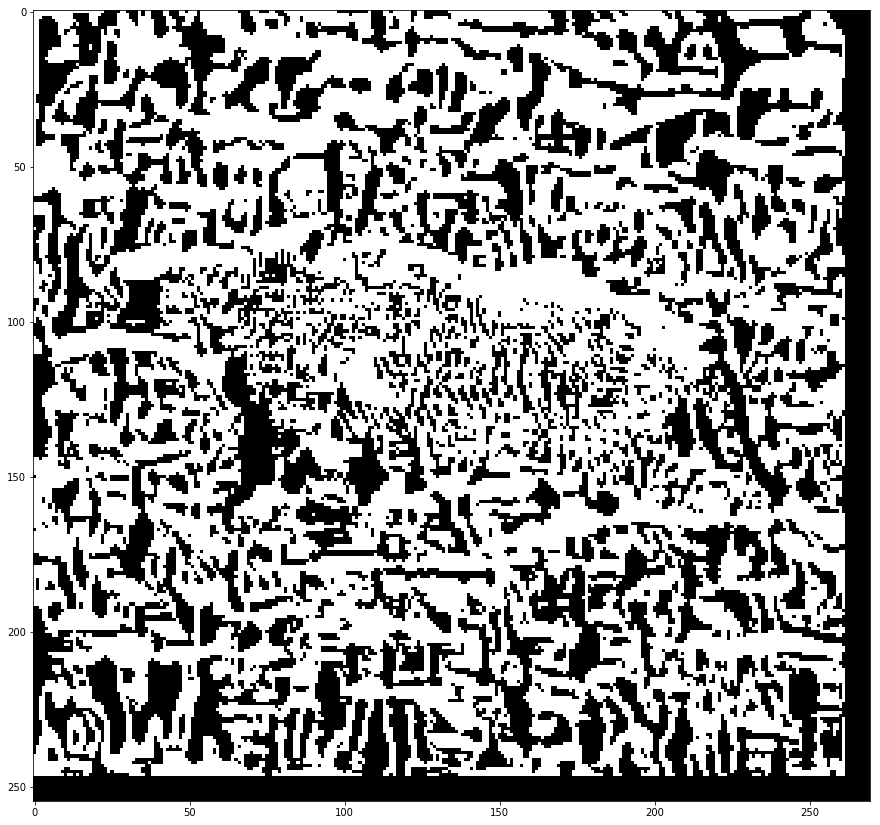

In [114]:
print(cheetahmask.shape)
plt.figure(figsize=(15,15))
plt.imshow(cheetahmask, cmap='gray')
plt.show()

In [110]:
idx = np.argpartition(x,-2)[-2]
print(idx)
print(x[idx])

[1 0 2]
[[ 0.50858747  0.24699736  0.92889331]
 [ 0.58864742  0.28905881  0.06898358]
 [ 0.76895308  0.85417862  0.43316622]]


In [111]:
x = np.array([1,0,1,1], dtype=bool)
x

array([ True, False,  True,  True], dtype=bool)

In [112]:
x = np.random.rand(3,3)
idx = np.array([[0,2,4],[1,3,5],[6,7,8]])
idxflat = np.ndarray.flatten(idx)
xflat = np.ndarray.flatten(x)
print(x)
print(idx)
print(xflat[idxflat])
print(idxflat)
print(xflat)
# x_ordered = np.zeros((1,64))
# x_ordered[idxflat] = xflat
# print(x)
# print(x_ordered)

[[ 0.32888944  0.53158461  0.92677411]
 [ 0.022565    0.20838585  0.98003024]
 [ 0.96427759  0.0396756   0.30369114]]
[[0 2 4]
 [1 3 5]
 [6 7 8]]
[ 0.32888944  0.92677411  0.20838585  0.53158461  0.022565    0.98003024
  0.96427759  0.0396756   0.30369114]
[0 2 4 1 3 5 6 7 8]
[ 0.32888944  0.53158461  0.92677411  0.022565    0.20838585  0.98003024
  0.96427759  0.0396756   0.30369114]
